In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB3, ResNet50, VGG16

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [5]:
base_dir = './pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
#        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
#     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


IndexError: list index out of range

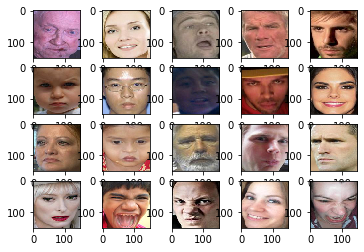

In [7]:
fig = plt.figure()
fig_arr = list()
for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, lable_batch in train_generator:
    for idx, img_data in enumerate(data_batch):
        fig_arr[idx].imshow(img_data/255, cmap='gray')
    break

plt.tight_layout()
plt.show()

# 전이 학습

In [8]:
# pretrained network
model_base = ResNet50(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

In [9]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 358407    
Total params: 23,946,119
Trainable params: 358,407
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/20
159/159 [==============================] - 56s 319ms/step - loss: 3.2956 - accuracy: 0.2817 - val_loss: 1.8857 - val_accuracy: 0.3918
Epoch 2/20
159/159 [==============================] - 49s 308ms/step - loss: 2.2060 - accuracy: 0.4177 - val_loss: 1.7930 - val_accuracy: 0.4367
Epoch 3/20
159/159 [==============================] - 49s 308ms/step - loss: 1.8722 - accuracy: 0.4775 - val_loss: 1.6701 - val_accuracy: 0.4762
Epoch 4/20
159/159 [==============================] - 49s 309ms/step - loss: 1.5659 - accuracy: 0.5330 - val_loss: 1.6900 - val_accuracy: 0.4644
Epoch 5/20
159/159 [==============================] - 49s 308ms/step - loss: 1.3330 - accuracy: 0.5796 - val_loss: 1.6291 - val_accuracy: 0.4872
Epoch 6/20
159/159 [==============================] - 49s 308ms/step - loss: 1.1807 - accuracy: 0.6168 - val_loss: 1.6886 - val_accuracy: 0.4844
Epoch 7/20
159/159 [==============================] - 49s 308ms/step - loss: 1.0402 - accuracy: 0.6477 - val_loss: 1.6826 - val_ac

In [11]:
result = model.evaluate(test_generator)
print(result)

21/21 [==============================] - 10s 460ms/step - loss: 1.7153 - accuracy: 0.5251
[1.7152518033981323, 0.5250723361968994]


# 새로운 전이학습 모델

In [ ]:
# pretrained network
model_base = VGG16(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

In [ ]:
result = model.evaluate(test_generator)
print(result)